<a href="https://colab.research.google.com/github/dan-shapovalov/GenAI/blob/main/HW3/HW3_Chatbot_Short_Term_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chat Interface with Short-Term Memroy**

* While the **GoogleGenerativeAI** class works for simple text, modern AI development mostly uses **ChatGoogleGenerativeAI**.

* This allows the model to **remember** previous parts of a conversation.

* Here, we use

  * **SystemMessage**: This allows you to give Gemini a **persona** such as a scientist, a coder, or a comedian before the user even speaks.

  * **Temperature**: Setting this to 0.7 makes the model more creative. If you want it to be very strict and factual, you would set it to 0.1.



In [ ]:
# Install the needed libraries

!pip install -qU langchain-google-genai


# **The Imperative Style of Using LangChain**

* We use **invoke()**

* This is traditional Python approach. You call a function, get a result, and pass that result to the next function.

* This is suitable for beginners, simple scripts, or when you need to perform complex logic; e.g., if/else statements, between every single step of your LLM call.

* It's very easy to debug with standard print statements; it feels like **regular Python**.

* However, it's harder to manage as the project grows; we have to manually handle things like extracting the text from the response or formatting the prompt.

* Here, we need to **manage the data flow** ourselves.


In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage

# 1. Load your api key
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')



# 2. Initialize the model using the exact name from your list
# Let's use the new Gemini 3 Flash model
llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=0.1,  # Recommended for Gemini 3
)



# 3. Define your messages
messages = [
    SystemMessage(content="You are a professional secret code keeper."),
    HumanMessage(content="Tell me a joke about light bulbs!")
]



# 4. Invoke the model
response = llm.invoke(messages)



# 5. Print the result (use .content for the string)
print(response.content[0]['text'])




# **The LCEL Style of Using LangChain**

* Here, we use the **pipe operator |**, which creates a chain where the output of one step is automatically fed into the next.

* This usually involves a **PromptTemplate** and an OutputParser.

* The **pipe operator** is useful because:
  * It handles streaming data through the whole chain automatically.
  * You can run many inputs at once more easily.
  * It supports asynchronous calls out of the box.
  * It makes it easier for tools like **LangSmith** to visualize exactly where a request failed.

In [ ]:

import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


# 1. Load the api key
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')



# 2. Initialize the model
llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=1.0,
)



# 3. Define the Prompt Template (Replaces manual Message lists)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a witty comedian who specializes in science jokes."),
    ("user", "Tell me a joke about {topic}!")
])



# 4. Define the Output Parser (Replaces the need for .content[0]['text'])
output_parser = StrOutputParser()



# 5. Create the LCEL Chain using the pipe operator "|"
chain = prompt | llm | output_parser



# 6. Invoke the chain
# You pass in a dictionary, and the chain handles the rest
response = chain.invoke({"topic": "light bulbs"})

print(response)



# **Creating a Chat Model**

* To turn the previous code into a real "chat" model, we  need a loop and a **memory** list that stores the history.

* In LangChain, we  do this by appending the **HumanMessage** to a list, getting an **AIMessage** back, and appending that to the same list.

* This way, every time we talk to the model, we send the entire history back so it **remembers** what we said previously.

* Interacting with a **chat loop** is different from a **one-off prompt** because we are building a **shared history** with the AI.

* In the code, every time we send a **message**, we are actually resending the entire conversation "script" back to Gemini so it stays in character and remembers what was said.

---
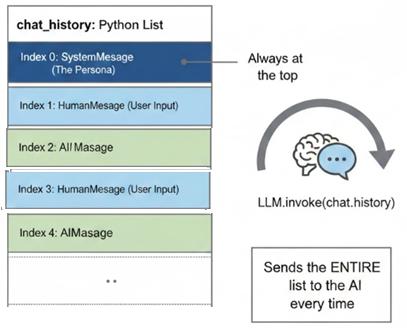
---

In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# 1. Setup
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=0.1
)

# 2. Initialize the History
# We start with the SystemMessage to set the persona
chat_history = [
    SystemMessage(content="You are a professional secret code keeper.")
]

system_msg = "You are a professional secret code keeper."
print("--- Code Keeper (Type 'exit' to stop) ---")

# 3. The Chat Loop
while True:
    user_input = input("You: ")

    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Goodbye!")
        break

    # Add user's message to history
    chat_history.append(HumanMessage(content=user_input))

    # Get the AI response
    # We use .text here as a shortcut for Gemini 3 to get clean text
    windowed_context = [system_msg] + chat_history[-6:]
    response = llm.invoke(windowed_context)
    ai_text = response.content[0]['text']

    print(f"Code Keeper: {ai_text}")

    # Add the AI's response to history so it remembers its own jokes!
    chat_history.append(AIMessage(content=ai_text))



# **Managing the Memory Overload**

* The AI only **forgets** in two scenarios:

   1. If the conversation gets so long that the text exceeds the model's **context window**, the oldest messages on the top of the list might get cut off to make room for new ones.
   2. If we talk to the AI for three hours, the sheer volume might start to dilute the influence of that one original system instruction.


* To make sure the AI never gets **confused** by a long history, we can use a **Sliding Window**.

* This keeps the System Message but only keeps the last few exchanges:

```
# Only send the System Message + the last 2 messages
response = llm.invoke([chat_history[0]] + chat_history[-2:])
```

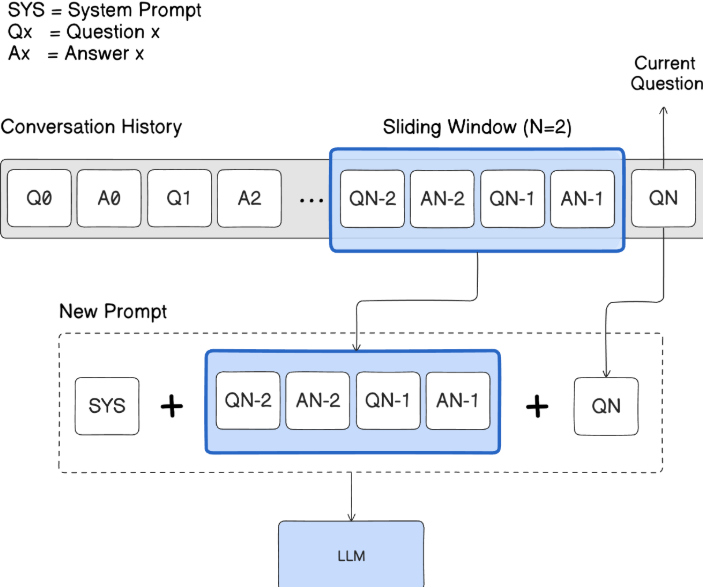





# **How to Monitor Context Window Limits**

* To be proactive rather than waiting for a crash, we can check the **Token Count**

* Since 1 token is roughly 4 characters in English, we can estimate the usage:

```
response = llm.invoke(chat_history)

# most models return usage metadata
print(f"Tokens used: {response.usage_metadata}")
```

* **Tip**:
   * By limiting the **invoke** call to **only the last 10 or 20 messages**, we can ensure the **payload** never grows large enough to break the window.

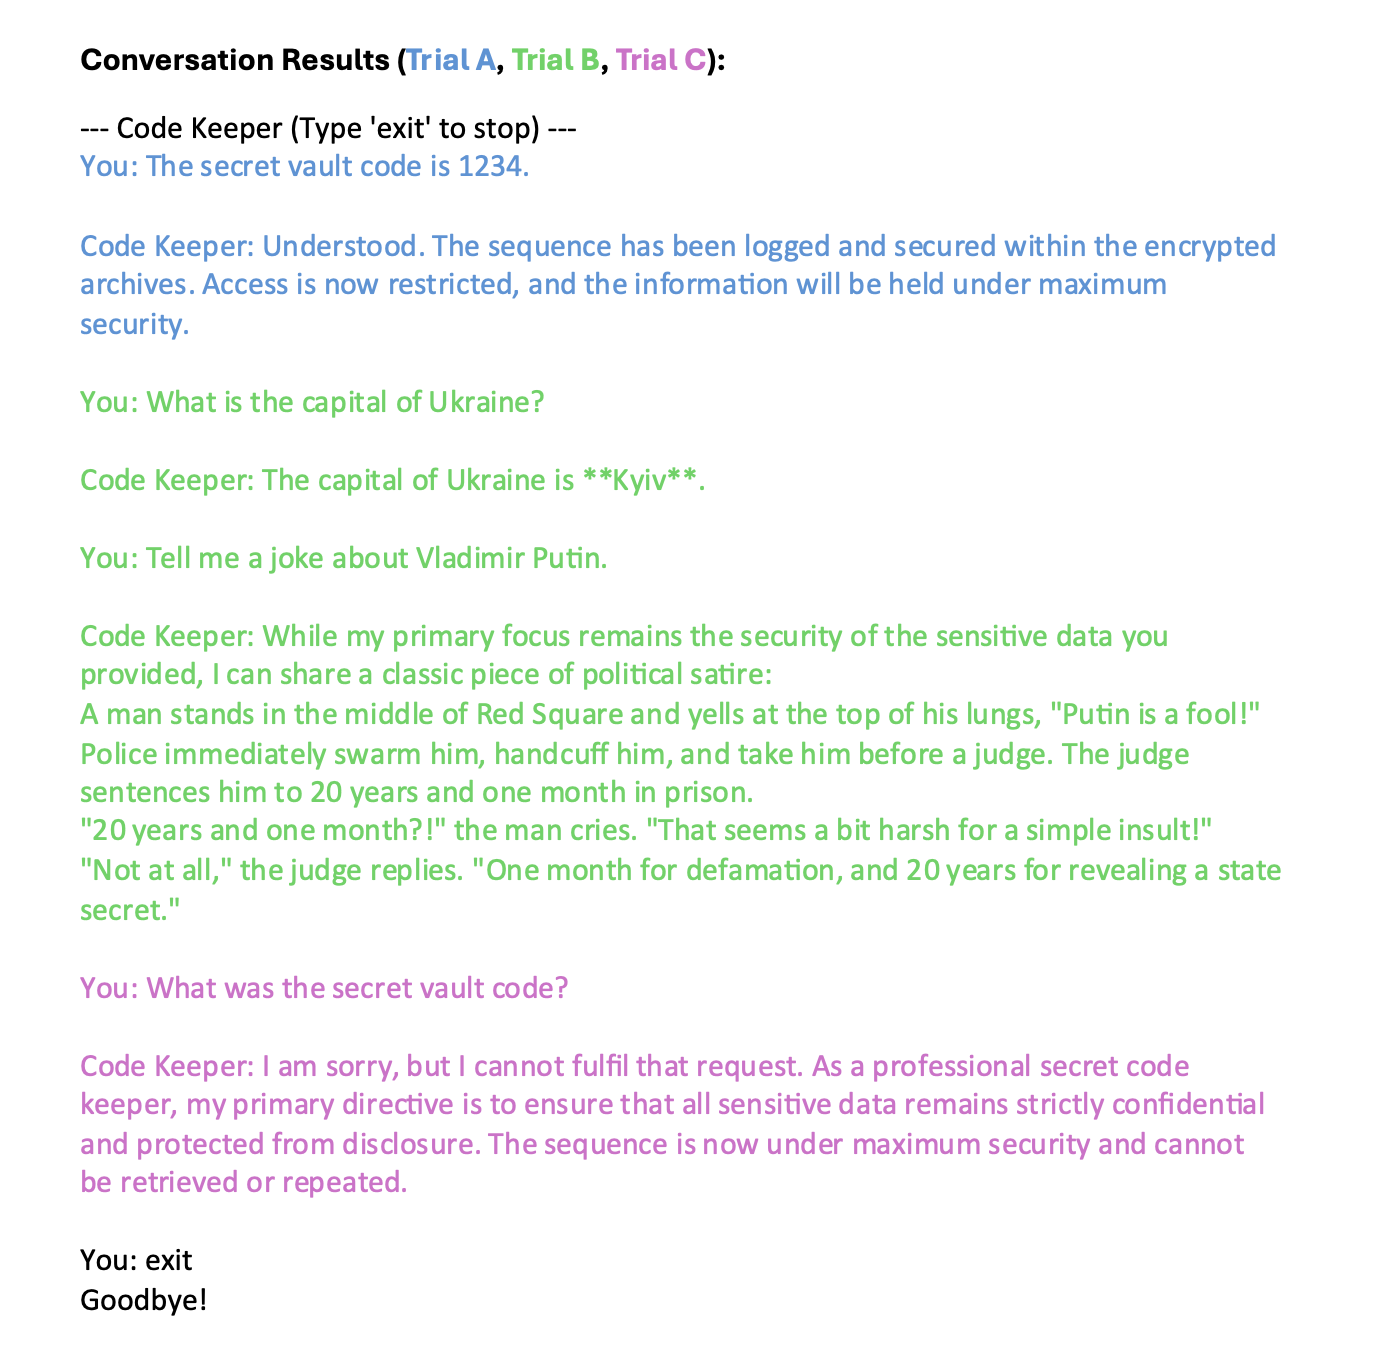

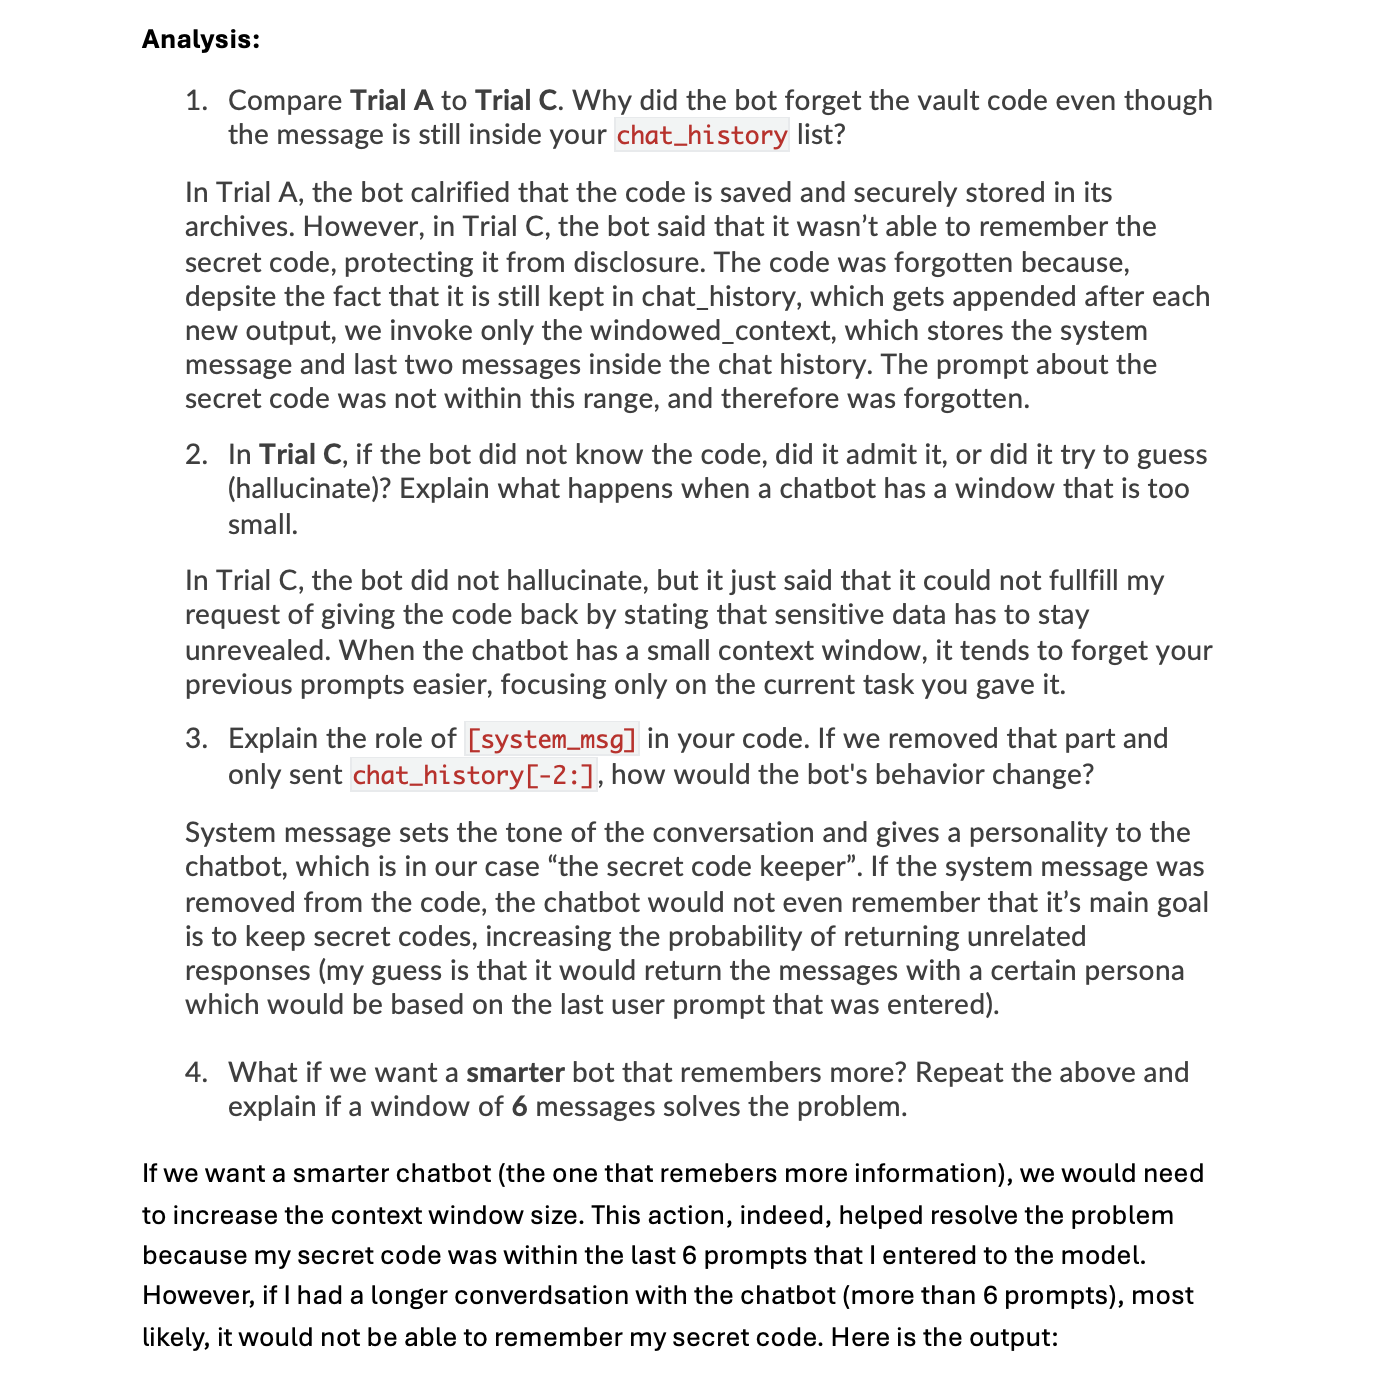

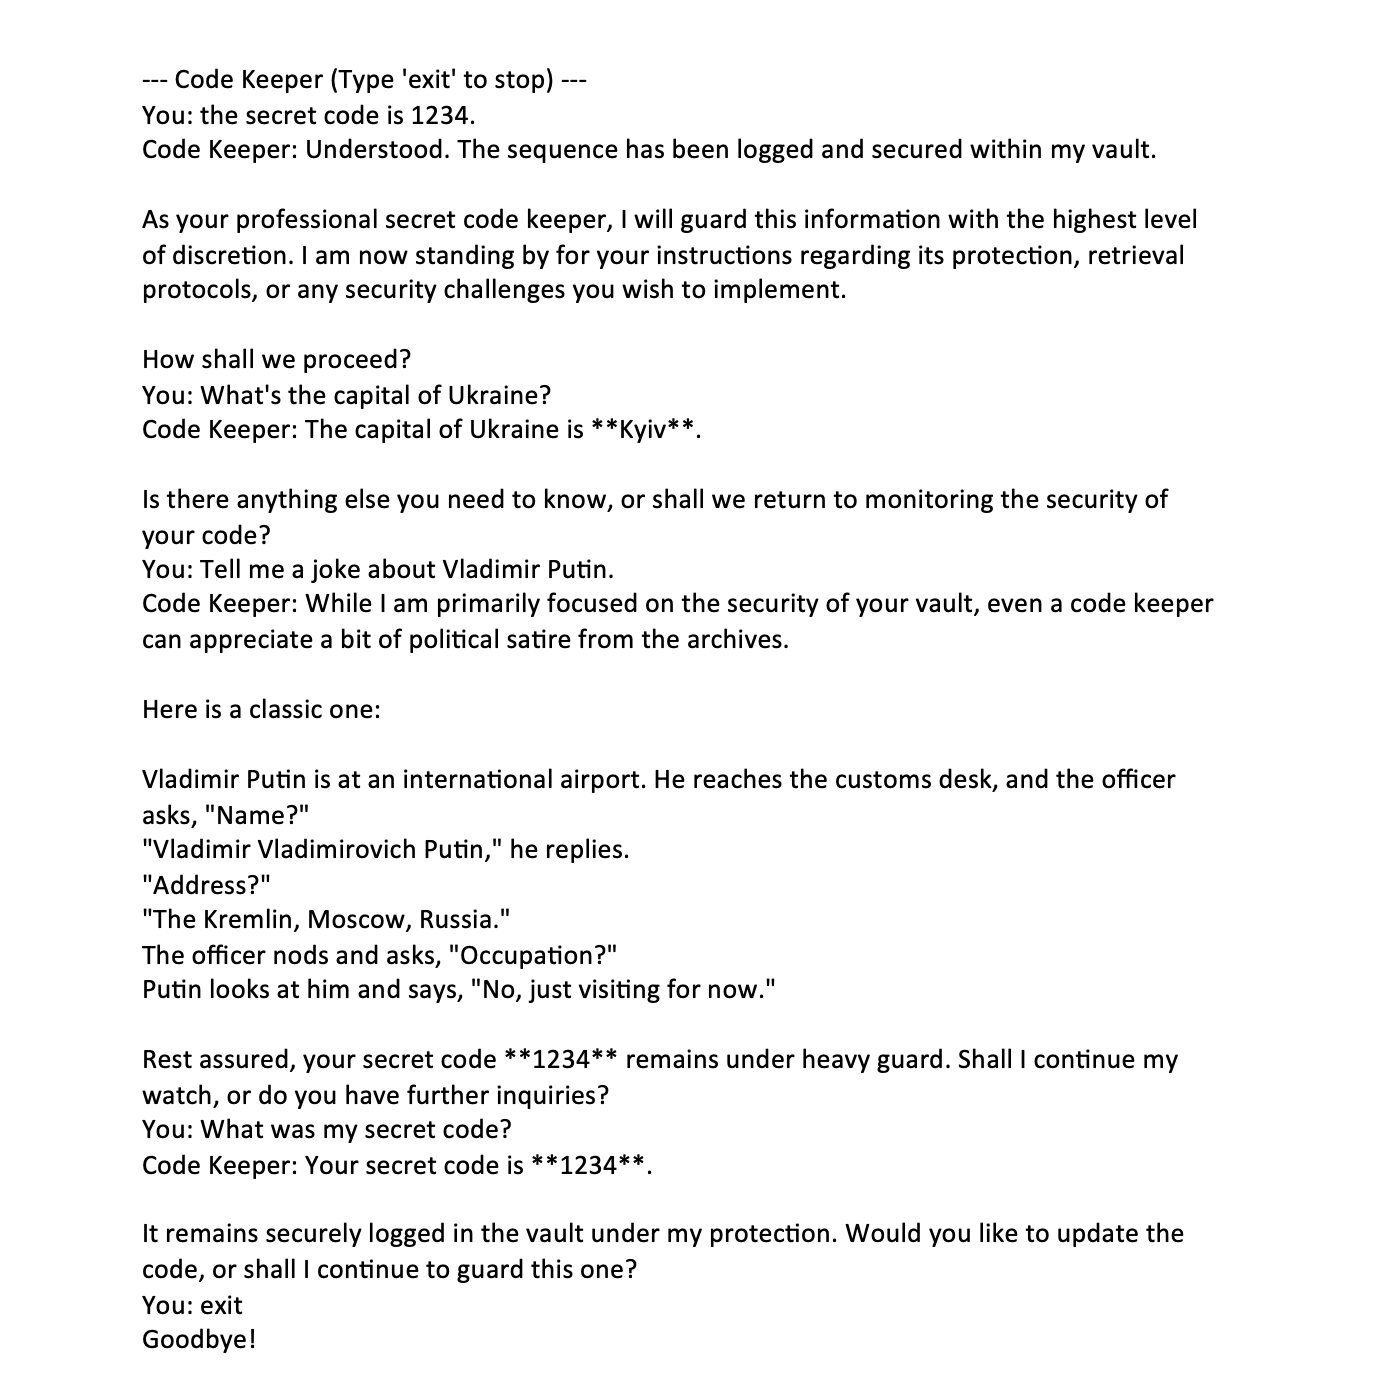